<a href="https://colab.research.google.com/github/KameronKeller/Grid-World-Deep-Q-Learning/blob/main/GridWorldDeepQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grid World Deep Q-Learning

***
# Load packages 
***

In [2]:
!pip install gymnasium
!pip install gymnasium[toy_text]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.1/879.1 KB 45.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 70.8 MB/s eta 0:00:00


In [3]:
import gymnasium as gym
import sys
import numpy as np
import tensorflow as tf
import matplotlib.animation
import matplotlib.pyplot as plt

from collections import deque

In [4]:
# Setup plotting to display matplotlib animations
plt.rc('animation', html='jshtml')

### Load dataset

In [5]:
# load your dataset 
# Create a 'FrozenLake' environment. Initally, is_slippery is false to prevent agent from unpredictable sliding on the lake
# More info: https://gymnasium.farama.org/environments/toy_text/frozen_lake/
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")

### Pre-process dataset

In [6]:
# Number of states
n_states = env.observation_space.n
print("Number of states: ", n_states)

# Determine the number of outputs
n_actions = env.action_space.n
print("Number of actions: ", n_actions)

Number of states:  16
Number of actions:  4


***
# Workspace
***

##### Helper Functions

In [7]:
# Use the model to predict the next move
def next_move(obs, model):

    # Get the predictions for possible actions
    moves = model.predict([obs], verbose=0)[0]

    # Return the best prediction 
    action = np.argmax(moves)
    return action

In [8]:
# Play the game
# Adapted from: Hands on Machine Learning by Géron
def play_game(env, model):
    n_max_steps = 100
    frames = []
    obs, info = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render())
        action = next_move(obs, model)
        obs, reward, done, truncated, info = env.step(action)
    env.close()
    return frames

In [9]:
# Get sample experiences from the replay buffer
# Source: Hands on Machine Learning by Géron
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

In [10]:
# The training step
# Source: Hands on Machine Learning by Géron
def training_step(batch_size, optimizer, discount_factor):

    # Get a sample batch of experiences
    experiences = sample_experiences(batch_size)

    # Get the variables of those experiences
    states, actions, rewards, next_states, dones, truncateds = experiences

    # Get the Q-Value for the each possible action
    next_Q_values = model.predict(next_states, verbose=0)

    # Get the max Q-Values from the predictions
    max_next_Q_values = next_Q_values.max(axis=1)

    # Runs = 1 if episode runs
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated

    # Compute target Q value
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values

    # Reshape the output to appropriate format
    target_Q_values = target_Q_values.reshape(-1, 1)

    # Mask all actions we do not need. Example: mask = [[0 0 0 1], [1 0 0 0]...]
    mask = tf.one_hot(actions, n_actions)

    # Gradient descent step to minimize the loss
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Return loss for plotting
    return loss

In [11]:
# Return a random action based on probability, or choose the best action
# Source: Hands on Machine Learning by Géron
def epsilon_greedy_policy(state, epsilon, n_actions):
    if np.random.rand() < epsilon: # original
        return np.random.randint(n_actions)  # random action
    else:
        Q_values = model.predict([state], verbose=0)
        return Q_values.argmax()  # optimal action according to the DQN

In [12]:
# Play one step in the environment
# Source: Hands on Machine Learning by Géron
def play_one_step(env, state, epsilon, n_actions):
    action = epsilon_greedy_policy(state, epsilon, n_actions)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [13]:
# Train the model
# Adapted from: Hands on Machine Learning by Géron
def train_model(env, model, num_iterations, optimizer, discount_factor, verbose=True):
  # Store the number of wins (1 for each time 'done' is true)
  win_counter = 0

  # Store the rewards from each episode for graphing
  rewards = []

  # Store the losses for graphing
  losses = []

  # Variable for storing the best score
  best_score = 0

  for episode in range(num_iterations):

      # Reset the environment
      obs, info = env.reset()

      # 100 steps is the max for the frozen lake environment
      for step in range(100): # max for frozen lake

          # Epsilon is the probability of exploring. It decays to 0.01 after the world is explored
          epsilon = max(1 - episode / 500, 0.01) # probability of exploring

          # Play one step and get the variables
          obs, reward, done, truncated, info = play_one_step(env, obs, epsilon, n_actions)

          # Keep track of the wins
          if reward == 1:
            win_counter += 1

          # if done or truncated, start next episode
          if done or truncated:
            break

      # extra code – displays debug info, stores data for the next figure, and
      #              keeps track of the best model weights so far
      if verbose:
        print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
              end="")

      # Append the reward to rewards for graphing    
      rewards.append(reward)
    
      # The best model will obtain the reward in the least moves
      if reward >= best_score: 
          best_weights = model.get_weights()
          best_score = reward

      # Wait till replay buffer is filled before training
      if episode > 50:
          loss = training_step(batch_size, optimizer, discount_factor)
          losses.append(loss)

  # Calculate the win ratio
  win_ratio = win_counter / num_iterations

  # Restore the best model weights
  model.set_weights(best_weights)

  return model, rewards, losses, win_ratio

In [14]:
# Plot the sum of rewards
# Source: Hands on Machine Learning by Géron  
def plot_rewards(rewards):
  plt.figure(figsize=(8, 4))
  plt.plot(rewards)
  plt.title("Rewards")
  plt.xlabel("Episode", fontsize=14)
  plt.ylabel("Sum of rewards", fontsize=14)
  plt.grid(True)
  plt.show()

In [15]:
# Plot the losses
def plot_losses(losses):
  plt.figure(figsize=(8, 4))
  plt.title("Losses per Episode")
  plt.xlabel("Episode", fontsize=14)
  plt.ylabel("Losses", fontsize=14)
  plt.plot(losses)
  plt.grid(True)
  plt.show()

In [16]:
# Plot the win ratios
def plot_win_ratios(hyperparameter, win_ratios):
  plt.figure(figsize=(8, 4))
  plt.title("Win ratios per hyperparameter")
  plt.xlabel("Hyperparameter Value", fontsize=14)
  plt.ylabel("Win Ratio", fontsize=14)
  plt.plot(hyperparameter, win_ratios)
  plt.grid(True)
  plt.show()

In [17]:
# Plot the an environment
# Source: Hands on Machine Learning by Géron
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return

In [18]:
# Display an animation of an episode
# Source: Hands on Machine Learning by Géron
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

In [19]:
# Plot the animation
# Source: Hands on Machine Learning by Géron
def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

##### Model Definition

In [20]:
# Build a neural network model
def build_model(n_states, n_actions, dense_units, embedding_output_dim):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(n_states, embedding_output_dim),
    tf.keras.layers.Dense(dense_units, activation="relu"),
    tf.keras.layers.Dense(n_actions)
  ])
  # model.summary()
  return model

## Experiment(s)

##### Experiment Setup

##### Hyperparameters

In [21]:
# Set up deque as a replay buffer
replay_buffer = deque(maxlen=2000)

In [22]:
# Initial hyperparameters
# Number of iterations
iterations = 500

# Dense layer units
dense_units = 32

# Embedding output dimensions
embedding_output_dim = 4

# The batch size to sample
batch_size = 64

# The discount factor
discount_factor = 0.95

# Learning Rate
learning_rate = .001

# The optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# The loss function
loss_fn = tf.keras.losses.mean_squared_error

In [23]:
# Display the results of training
def display_results(results):
  model, rewards, losses, win_ratio = results
  print("Win ratio: {:.2f}".format(win_ratio))
  plot_rewards(rewards)
  plot_losses(losses)

##### Baseline Experiment

In [24]:
model = build_model(n_states, n_actions, dense_units, embedding_output_dim)

In [25]:
results = train_model(env, model, 1000, optimizer, discount_factor)

Episode: 1000, Steps: 6, eps: 0.010

Win ratio: 0.58


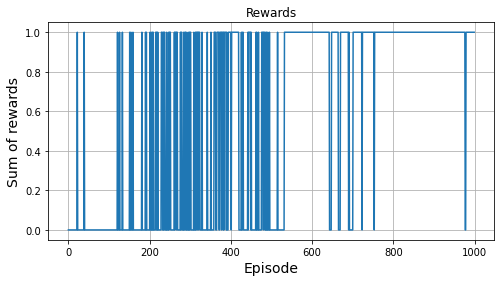

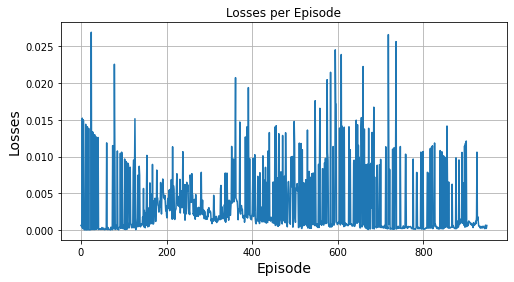

In [26]:
display_results(results)

#### Experiment 1 - Number of Dense Units

========== Experiment: Dense Units = 4 ==========
Win ratio: 0.35


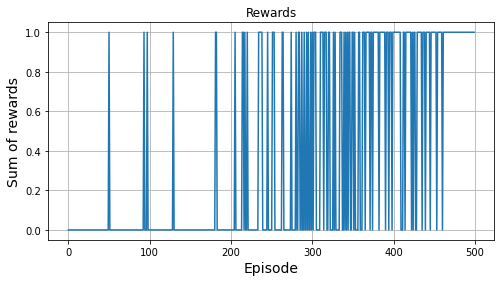

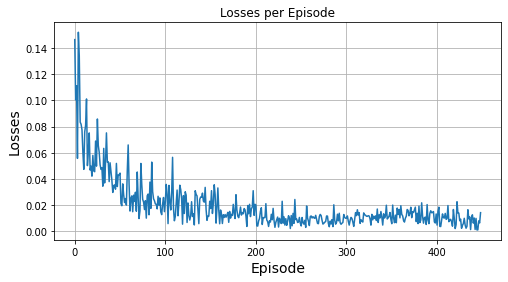

========== Experiment: Dense Units = 8 ==========
Win ratio: 0.36


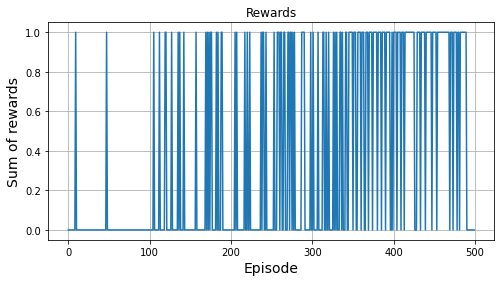

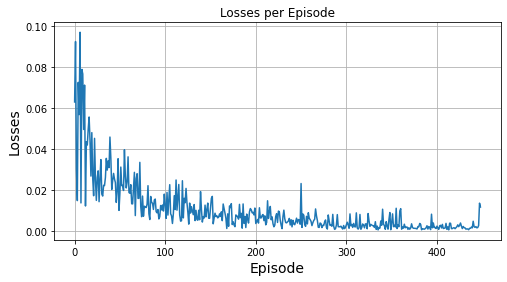

========== Experiment: Dense Units = 16 ==========
Win ratio: 0.24


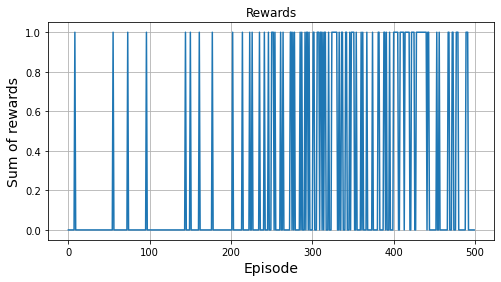

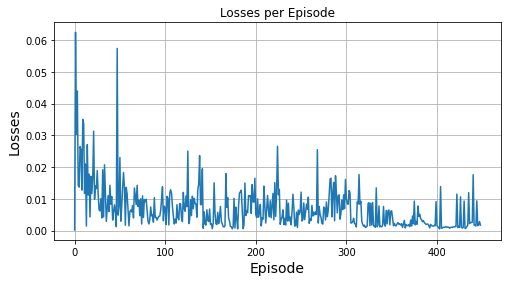

========== Experiment: Dense Units = 32 ==========
Win ratio: 0.20


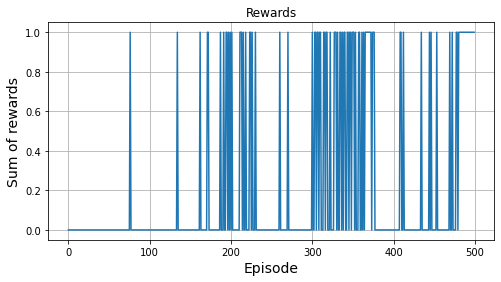

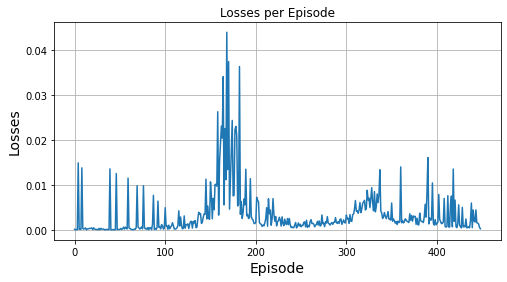

========== Experiment: Dense Units = 64 ==========
Win ratio: 0.29


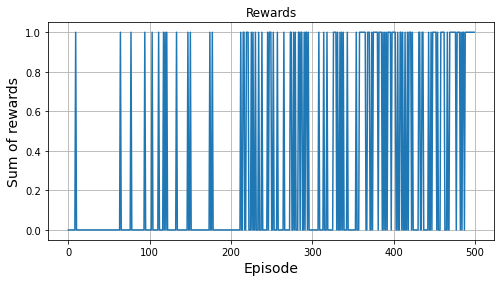

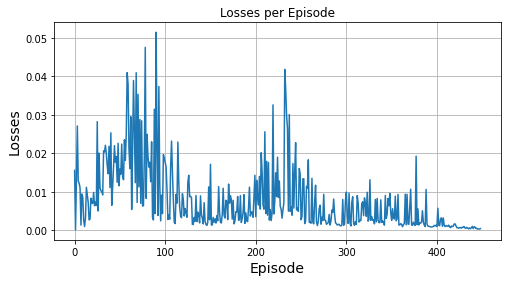

========== Results ==========
Best Parameter = 8, with win ratio of 0.36


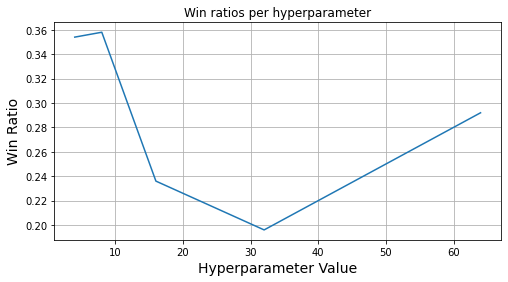

In [27]:
test_dense_units = [4, 8, 16, 32, 64]
win_ratios = []

for count, units in enumerate(test_dense_units):
  print("========== Experiment: Dense Units = {} ==========".format(units))
  model = build_model(n_states, n_actions, units, embedding_output_dim)
  results = train_model(env, model, iterations, optimizer, discount_factor, verbose=False)
  win_ratio = results[3]
  win_ratios.append(win_ratio)
  display_results(results)

print("========== Results ==========")
best_parameter_index = np.argmax(win_ratios)
print("Best Parameter = {}, with win ratio of {:.2f}".format(test_dense_units[best_parameter_index], win_ratios[best_parameter_index]))
plot_win_ratios(test_dense_units, win_ratios)

#### Experiment 2 - Number of Embedding Layer Output Dimensions

========== Experiment: Embedding Layer Output Dim = 2 ==========


Win ratio: 0.25


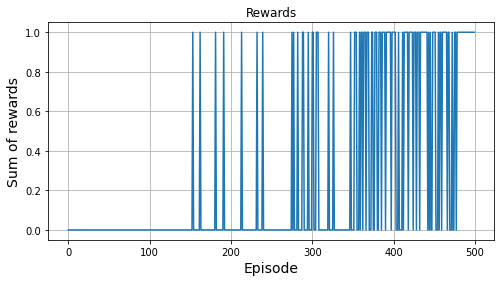

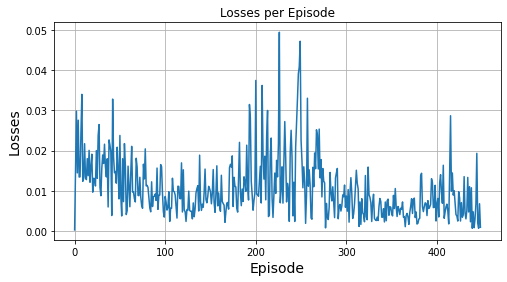

========== Experiment: Embedding Layer Output Dim = 3 ==========
Win ratio: 0.32


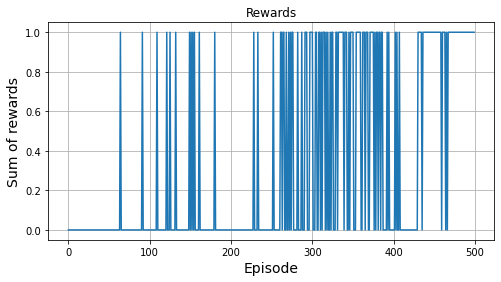

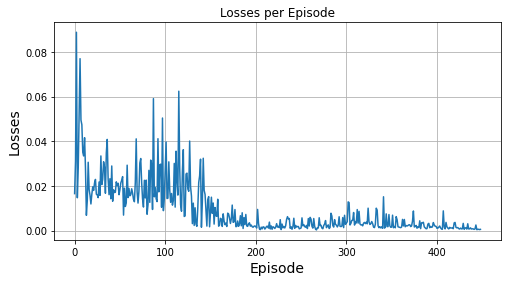

========== Experiment: Embedding Layer Output Dim = 4 ==========
Win ratio: 0.34


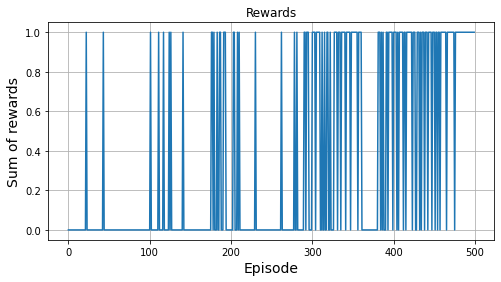

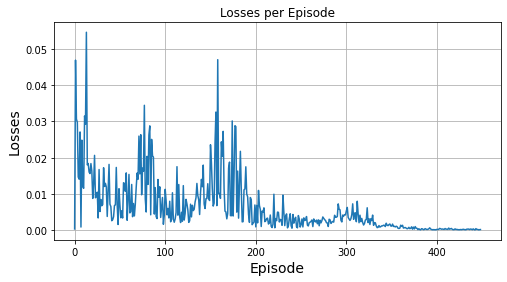

========== Experiment: Embedding Layer Output Dim = 5 ==========
Win ratio: 0.40


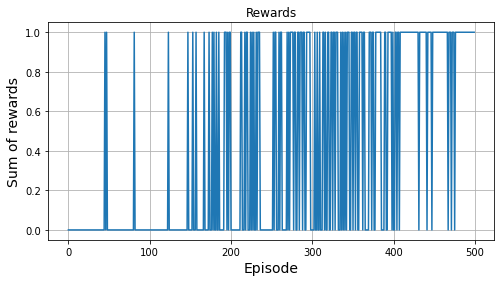

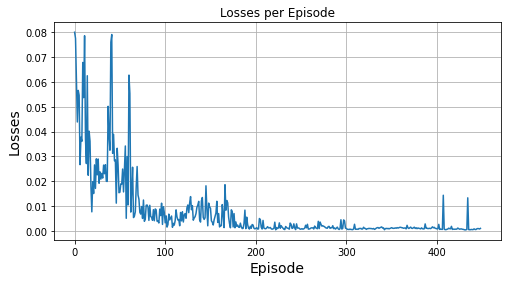

========== Experiment: Embedding Layer Output Dim = 6 ==========
Win ratio: 0.31


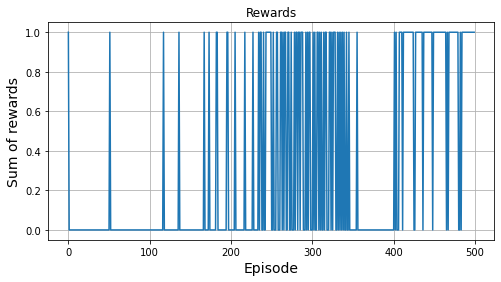

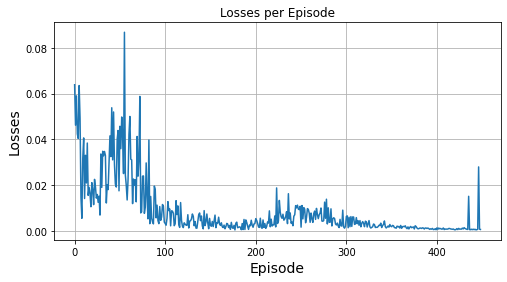

========== Results ==========
Best Parameter = 5, with win ratio of 0.40


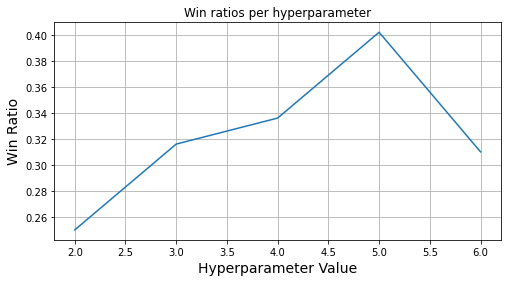

In [28]:
test_embedding_output_dims = [2, 3, 4, 5, 6]
win_ratios = []

for count, output_dim in enumerate(test_embedding_output_dims):
  print("========== Experiment: Embedding Layer Output Dim = {} ==========".format(output_dim))
  model = build_model(n_states, n_actions, dense_units, output_dim)
  results = train_model(env, model, iterations, optimizer, discount_factor, verbose=False)
  win_ratio = results[3]
  win_ratios.append(win_ratio)
  display_results(results)

print("========== Results ==========")
best_parameter_index = np.argmax(win_ratios)
print("Best Parameter = {}, with win ratio of {:.2f}".format(test_embedding_output_dims[best_parameter_index], win_ratios[best_parameter_index]))
plot_win_ratios(test_embedding_output_dims, win_ratios)

#### Experiment 3 - Discount Factor

========== Experiment: Discount Factor = 0.92 ==========


Win ratio: 0.38


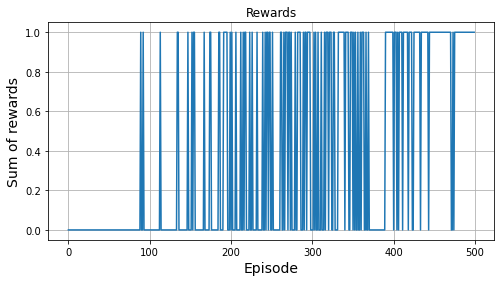

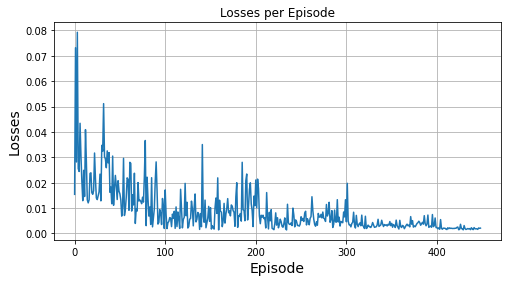

========== Experiment: Discount Factor = 0.95 ==========
Win ratio: 0.33


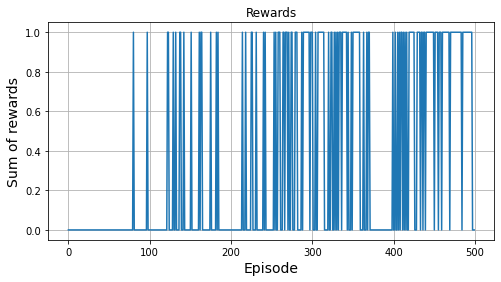

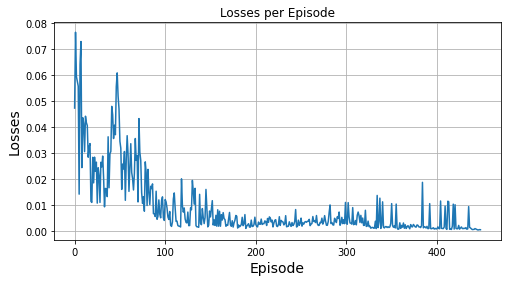

========== Experiment: Discount Factor = 0.97 ==========
Win ratio: 0.21


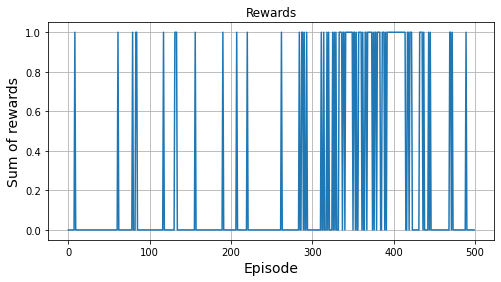

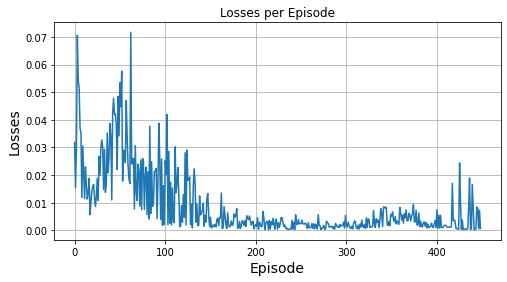

========== Experiment: Discount Factor = 0.99 ==========
Win ratio: 0.01


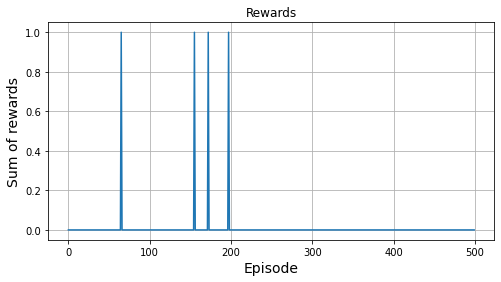

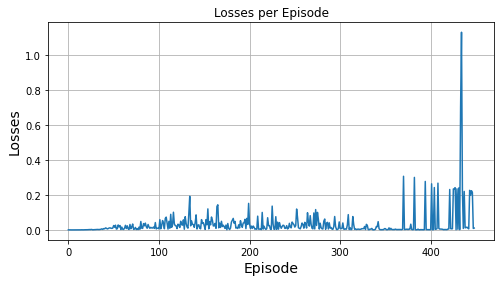

========== Results ==========
Best Parameter = 0.92, with win ratio of 0.38


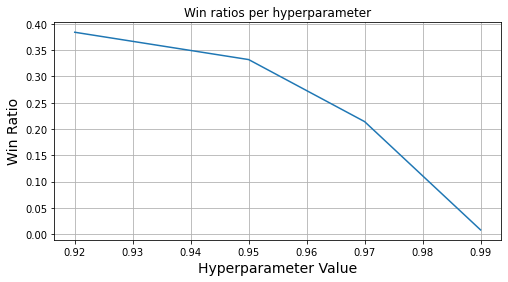

In [29]:
test_discount_factors = [0.92, 0.95, 0.97, 0.99]
win_ratios = []

for count, discount_factor in enumerate(test_discount_factors):
  print("========== Experiment: Discount Factor = {} ==========".format(discount_factor))
  model = build_model(n_states, n_actions, dense_units, embedding_output_dim)
  results = train_model(env, model, iterations, optimizer, discount_factor, verbose=False)
  win_ratio = results[3]
  win_ratios.append(win_ratio)
  display_results(results)

print("========== Results ==========")
best_parameter_index = np.argmax(win_ratios)
print("Best Parameter = {}, with win ratio of {:.2f}".format(test_discount_factors[best_parameter_index], win_ratios[best_parameter_index]))
plot_win_ratios(test_discount_factors, win_ratios)

#### Experiment 4 - Optimizer

========== Experiment: Optimizer = <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fec01d3f130> ==========


Win ratio: 0.30


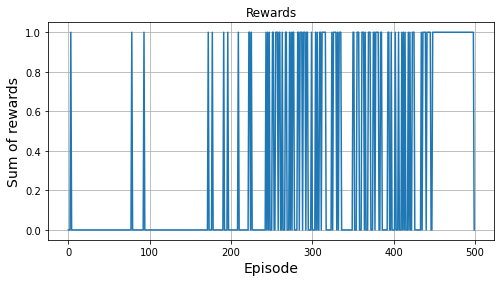

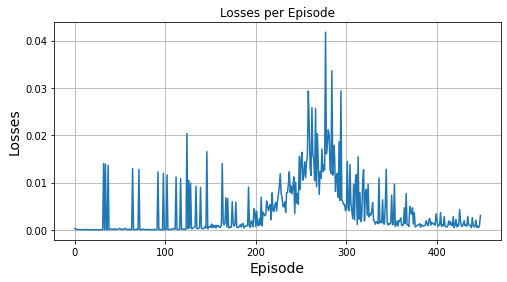

========== Experiment: Optimizer = <keras.optimizers.optimizer_v2.gradient_descent.SGD object at 0x7fec01d3f820> ==========
Win ratio: 0.00


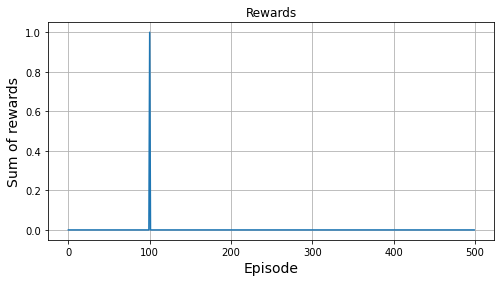

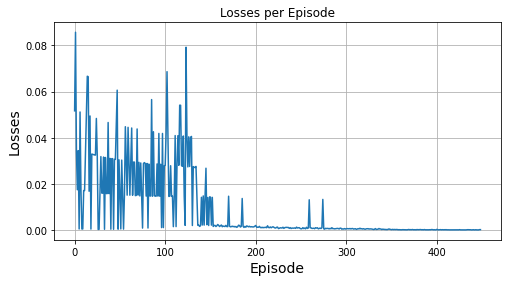

========== Results ==========
Best Parameter = <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fec01d3f130>, with win ratio of 0.30


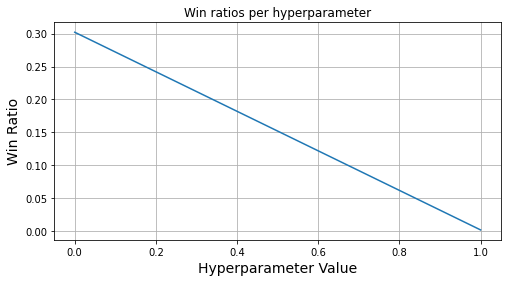

In [30]:
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

# Reset the discount_factor
discount_factor = 0.95
test_optimizers = [adam, sgd]
win_ratios = []

for count, optimizer in enumerate(test_optimizers):
  print("========== Experiment: Optimizer = {} ==========".format(optimizer))
  model = build_model(n_states, n_actions, dense_units, embedding_output_dim)
  results = train_model(env, model, iterations, optimizer, discount_factor, verbose=False)
  win_ratio = results[3]
  win_ratios.append(win_ratio)
  display_results(results)

print("========== Results ==========")
best_parameter_index = np.argmax(win_ratios)
print("Best Parameter = {}, with win ratio of {:.2f}".format(test_optimizers[best_parameter_index], win_ratios[best_parameter_index]))
plot_win_ratios(list(range(len(test_optimizers))), win_ratios)

#### Experiment 5 - Learning Rate

========== Experiment: Learning Rate = 0.001 ==========


Win ratio: 0.17


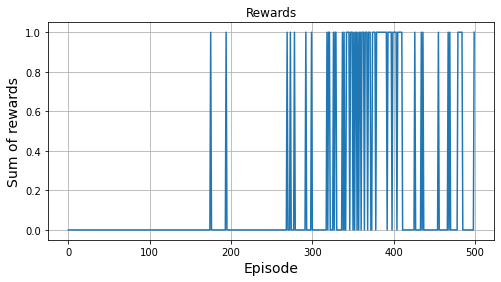

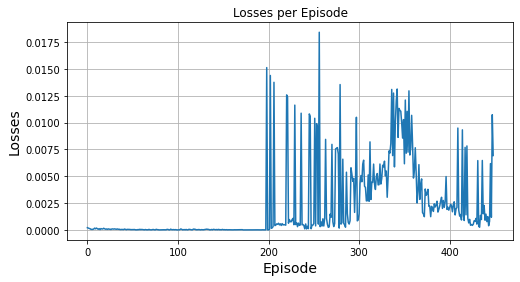

========== Experiment: Learning Rate = 0.0001 ==========
Win ratio: 0.01


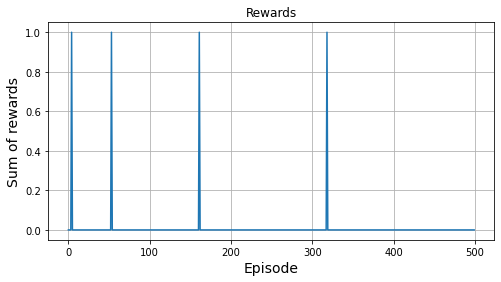

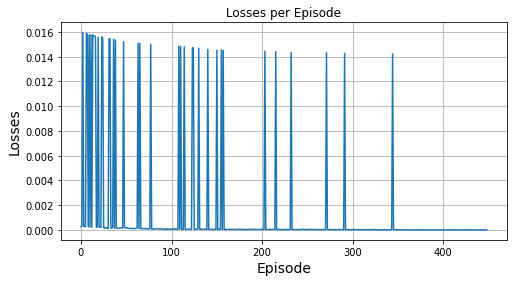

========== Experiment: Learning Rate = 1e-05 ==========
Win ratio: 0.00


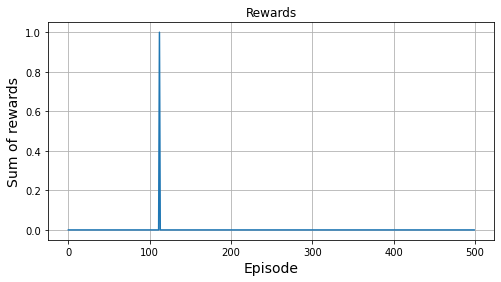

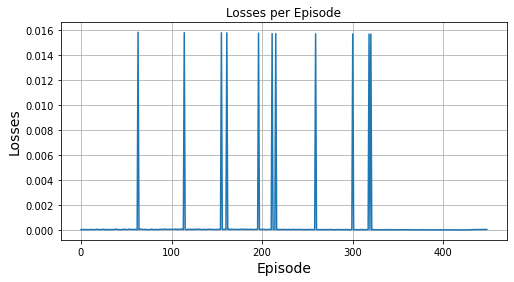

========== Results ==========
Best Parameter = 0.001, with win ratio of 0.17


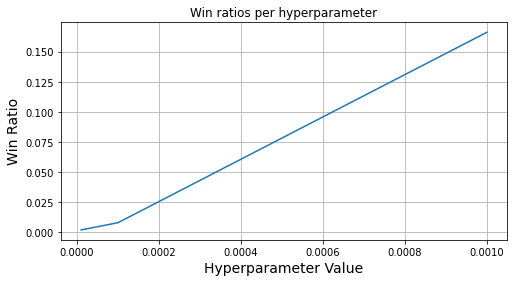

In [31]:
test_learning_rates = [0.001, 0.0001, 0.00001]
win_ratios = []

for count, learning_rate in enumerate(test_learning_rates):
  print("========== Experiment: Learning Rate = {} ==========".format(learning_rate))
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model = build_model(n_states, n_actions, dense_units, embedding_output_dim)
  results = train_model(env, model, iterations, optimizer, discount_factor, verbose=False)
  win_ratio = results[3]
  win_ratios.append(win_ratio)
  display_results(results)

print("========== Results ==========")
best_parameter_index = np.argmax(win_ratios)
print("Best Parameter = {}, with win ratio of {:.2f}".format(test_learning_rates[best_parameter_index], win_ratios[best_parameter_index]))
plot_win_ratios(test_learning_rates, win_ratios)

In [32]:
# Build a new model with the best hyperparameters

# Number of iterations
iterations = 1000

# Dense layer units
dense_units = 32

# Embedding output dimensions
embedding_output_dim = 5

# The batch size to sample
batch_size = 64

# The discount factor
discount_factor = 0.92

# Learning Rate
learning_rate = .001

# The optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# The loss function
loss_fn = tf.keras.losses.mean_squared_error

Episode: 8, Steps: 8, eps: 0.986

Episode: 1000, Steps: 6, eps: 0.010Win ratio: 0.68


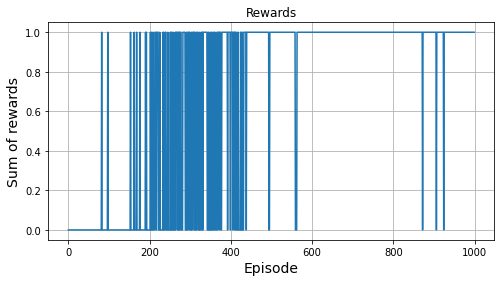

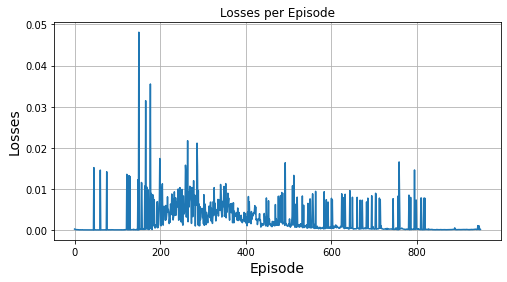

In [33]:
model = build_model(n_states, n_actions, dense_units, embedding_output_dim)
results = train_model(env, model, iterations, optimizer, discount_factor, verbose=True)
display_results(results)

***
# Report
***

## Deep Q-Learning with Frozen Lake

### Introduction

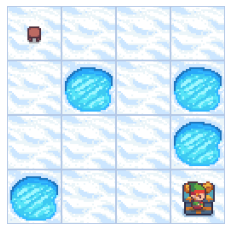

In [34]:
plot_environment(env)

### Introduction

[Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) is a simple grid world where an agent must dodge holes in a frozen lake in order to reach a reward. A combination of Q-Learning and Deep Learning, Deep Q-Learning (DQN), was used to successfully train an agent to navigate the grid world to reach a reward. 
 
To determine the optimal hyperparameters for the machine learning model, research was conducted on the impacts of five different hyperparameters on the model's effectiveness. The most effective hyperparameters were then chosen and applied to a new model. Finally, the new model was tested to determine a final outcome.

### Dataset and Pre-processing
In contrast to a traditional machine learning problem where a large dataset is analyzed and used to make predictions, DQNs utilize an actor-critic method for generating training data. The actor-critic method involves an agent acting on an environment. Based on the agent's action, either a reward or punishment is received. This outcome is fed into the DQN and used to make future predictions based on a given state in the environment.

In the Frozen Lake environment, there are 16 possible states. The agent begins in the top left corner of the map, and a gift is in the bottom right corner of the map. The agent has four possible actions: move up, down, left, or right. If the agent reaches the gift, it receives a reward of "1", and for all other spaces it receives a reward of "0". 

<img src="https://gymnasium.farama.org/_images/AE_loop.png" alt="actor-critic" width="400"/>

[Source](https://gymnasium.farama.org/content/basic_usage/)

### Methods
The process for building a DQN and optimizing it followed these basic steps:
1. Build a working DQN, including helper functions needed to output Q-values (quality values).
2. Identify key hyperparameters and run tests on these parameters to determine their effect on the model.
3. Build and test a new model based on the highest-performing hyperparameters from step 2.

#### Building the DQN 
To build the DQN, several components are needed. It needs a neural network, a replay buffer, a greedy function, and a training function. 

The neural network for this problem was composed of the following layers:
* An embedding layer with 16 input dimensions (to match the 4x4 grid)
* A dense layer
* An output layer, with 4 outputs (to match the 4 possible actions the agent may take)

An embedding layer is useful for this problem, as it maps indices to dense vectors. It is an efficient way to encode inputs as one-hot vectors.

This implementation uses a replay buffer (deque) to store the agent's experiences during training. For each training episode, the replay buffer is sampled at random so that the DQN training is not based only on the most recent experiences. This improves the quality of the training by reducing correlations in the training batch. 

When a new Frozen Lake environment is created, the untrained model is blind to the results of movement to any new space on the map. Therefore, it must incorporate a sort of exploration policy so that it may explore the map. Without this exploration, the agent may never find the reward and will get stuck as no moves provide any benefit. To accomplish this, an `epsilon greedy policy` is used. Epsilon is the probability that the agent will explore. In this implementation, during training, the value of epsilon is linearly decreased until a minimum value (0.01). In other words, after each episode, the agent has a lower chance of exploring new spaces. In theory, by the time epsilon reaches a minimum, the agent has located the reward and has positive reinforcement to visit that area again. When the agent does not explore new spaces, it makes a greedy choice based on predicted values, given its state. That is, at any given location on the map, the agent chooses the one with the highest hope of reward.

With these components in place the following training algorithm was utilized (Géron, p. 636):
1. Get a sample batch of experiences from the replay buffer.
2. Predict the Q-values based on the state the sample experience left the agent in.
3. Choose the best Q-values.
4. Calculate the target Q-values. The target Q-value is the result of this equation: 𝑄<sub>target</sub>(𝑠, 𝑎) = 𝑟 + 𝛾 max 𝑄(𝑠′,𝑎′), where `r` is the rewards, `𝛾` is the discount factor, and `max 𝑄(𝑠′,𝑎′)` is the max Q-value from step 3.
5. One-hot encode the actions to zero-out unwanted Q-values.
6. Compute the loss and perform a gradient descent step to minimize the loss.

The discount factor in step 4 is critical. When the agent reaches the reward, every step leading up to the reward is given a fraction of the reward. The further the location from the final reward, the smaller the reward received.

#### Identifying the Best Hyperparameters
Through trial and error, five hyperparameters were identified that had a strong influence on the model's effectiveness. 
1. The number of units in the dense layer.
2. The output dimensions of the embedding layer.
3. The discount factor.
4. The learning rate.
5. The optimizer.

Initially, the following baseline parameters were chosen:
```python
# Dense layer units
dense_units = 32

# Embedding output dimensions
embedding_output_dim = 4

# Discount actor
discount_factor = 0.95

# Learning Rate
learning_rate = .001

# The optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
```

The following values were tested in small batches of 300 iterations:

```python
# Dense layer units
dense_units = [4, 8, 16, 32, 64]

# Embedding output dimensions
embedding_output_dim = [2, 3, 4, 5, 6]

# Discount actor
discount_factor = [0.92, 0.95, 0.97, 0.99]

# Learning Rate
learning_rate = .001

# The optimizer
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

optimizer = [adam, sgd]
```

Each the exception of the hyperparameter being tested, all other hyperparameters were set to the baseline parameters. The primary metric used to test the impact of the hyperparameters was a ratio of wins (reward reached) to the number of iterations (episodes).

Finally, the best hyperparameters were chosen, a new model was created, tested on 1,000 iterations, and compared to the baseline test.


### Results and Analysis
By independently analyzing the five hyperparameters specified above and tuning the model to the best hyperparameters, a 11% increase in the win ratio was achieved. The baseline test produced a win ratio of 57%, while the final test produced a win ratio of 68. The final model was not only successful but efficient. After approximately 175 iterations, the model often reached the "gift" in the environment.

| Model          | Win Ratio |
|----------------|-----------|
| Baseline Model | 0.57      |
| Updated Model  | 0.68      |

The below tables summarize the impact of each hyperparameter on the win ratio. The optimizer and learning rates had the largest impact on the win ratio. Discount factors below 0.99 appeared to be necessary for an effective model.

#### Number of Dense Units

| Number of Dense   Units | Win Ratio |
|-------------------------|-----------|
| 4                       | 0.01      |
| 8                       | 0.38      |
| 16                      | 0.36      |
| 32                      | 0.40      |
| 64                      | 0.29      |

#### Number of Embedding Layer Output Dimensions
| Number of Embedding   Layer Output Dimensions | Win Ratio |
|-----------------------------------------------|-----------|
| 2                                             | 0.28      |
| 3                                             | 0.20      |
| 4                                             | 0.35      |
| 5                                             | 0.42      |
| 6                                             | 0.37      |

#### Discount Factor
| Discount Factor | Win Ratio |
|-----------------|-----------|
| 0.92            | 0.40      |
| 0.95            | 0.37      |
| 0.97            | 0.09      |
| 0.99            | 0.00      |

#### Optimizer
| Optimizer | Win Ratio |
|-----------|-----------|
| Adam      | 0.33      |
| SGD       | 0.00      |

#### Learning Rate
| Learning Rate | Win Ratio |
|---------------|-----------|
| 0.001         | 0.34      |
| 0.0001        | 0.07      |
| 0.00001       | 0.01      |

#### Successfully Trained Model


In [35]:
frames = play_game(env, model)
plot_animation(frames)

### Discussion and Conclusion
DQN was a successful deep-learning model for solving Frozen Lake. Adjusting the hyperparameters produced a fast learning model with an overall win ratio of 69% during training.  Of the hyperparameters tested, the most important were the learning rate and the optimizer. A learning rate of 0.001 produced a 27% improvement over 0.0001. However, this is not a direct improvement. Had the model trained on more iterations, the slower learning rate might have produced better results. This is because a slow learning rate takes many iterations to find the optimal solution, while a faster learning rate may find it quickly but is possibly less accurate.

The Adam optimizer substantially outperformed the SGD optimizer. This is likely because it stores adaptive learning rates and requires less tuning than SGD. In this experiment, the parameters of the SGD optimizer were not tested or fine-tuned. It is possible that further testing will result in similar performance between Adam and SGD.

This experiment involved manually picking hyperparameters and testing them individually, largely due to the computation time needed for testing. Future testing utilizing methods like grid search would allow for a more expansive look into how each hyperparameter affects the other. Additionally, testing each hyperparameter on larger datasets (n > 10,000) may reveal new patterns that were hidden by this experiment's small test sizes. Finally, the range of values for each hyperparameter tested was narrow in this test. Expanding these ranges may also further optimizations and additional patterns not seen here.

### References


*   Google: [Playing CartPole with the Actor-Critic method](https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic#train_the_agent)
*   Géron, A. *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow*
* Jordan, J. [Setting the learning rate of your neural network.](https://www.jeremyjordan.me/nn-learning-rate/)
* Causevic, S. [Deep Reinforcement Learning: Build a Deep Q-network(DQN) with TensorFlow 2 and Gym to Play CartPole](https://towardsdatascience.com/deep-reinforcement-learning-build-a-deep-q-network-dqn-to-play-cartpole-with-tensorflow-2-and-gym-8e105744b998)
* Stack Overflow: (What is the difference between an Embedding Layer and a Dense Layer?)(https://stackoverflow.com/questions/47868265/what-is-the-difference-between-an-embedding-layer-and-a-dense-layer)

